In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
uploaded = files.upload()

# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 67 Mar  8 07:44 kaggle.json


In [0]:
!kaggle competitions download -c bengaliai-cv19
!mkdir zip_files
!mv ./* zip_files
!unzip 'zip_files/*.zip' -d input
!cp zip_files/*.csv input/
!rm -rf zip_files

  0% 0.00/4.75k [00:00<?, ?B/s]
100% 4.75k/4.75k [00:00<00:00, 8.61MB/s]
  0% 0.00/1.30M [00:00<?, ?B/s]
100% 1.30M/1.30M [00:00<00:00, 88.1MB/s]
 98% 973M/992M [00:03<00:00, 258MB/s]
100% 992M/992M [00:04<00:00, 255MB/s]
  0% 0.00/1.32M [00:00<?, ?B/s]
100% 1.32M/1.32M [00:00<00:00, 191MB/s]
  0% 0.00/16.8k [00:00<?, ?B/s]
100% 16.8k/16.8k [00:00<00:00, 17.4MB/s]
  0% 0.00/944 [00:00<?, ?B/s]
100% 944/944 [00:00<00:00, 748kB/s]
  0% 0.00/1.70k [00:00<?, ?B/s]
100% 1.70k/1.70k [00:00<00:00, 1.91MB/s]
  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 182MB/s]
  0% 0.00/1.18M [00:00<?, ?B/s]
100% 1.18M/1.18M [00:00<00:00, 172MB/s]
  0% 0.00/4.72k [00:00<?, ?B/s]
100% 4.72k/4.72k [00:00<00:00, 3.17MB/s]
  0% 0.00/1.25M [00:00<?, ?B/s]
100% 1.25M/1.25M [00:00<00:00, 177MB/s]
 99% 977M/986M [00:06<00:00, 60.2MB/s]
100% 986M/986M [00:06<00:00, 167MB/s] 
 98% 971M/991M [00:28<00:00, 55.5MB/s]
100% 991M/991M [00:28<00:00, 36.4MB/s]
 99% 981M/993M [00:18<00:00, 159MB/s]
100% 993M/9

In [0]:
!pip install iterative-stratification

In [0]:
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=5c636379393d6a42d7c26e9bbe14feb658c16741ef538ccb5a086616a908e729
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


# create folds

In [0]:
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if __name__ == "__main__":
    df = pd.read_csv("input/train.csv")
    df['kfold'] = -1
    # print(df)

    #shuffle the dataset and also reset its index
    df = df.sample(frac=1).reset_index(drop=True)

    x = df.image_id.values
    y = df[["grapheme_root", "vowel_diacritic", "consonant_diacritic"]].values

    mskf = MultilabelStratifiedKFold(n_splits=5)

    for fold, (trn_, val_) in enumerate(mskf.split(x,y)):
        # print("val : ", len(val_))
        print(f"Train :{trn_}, val : {val_}")
        df.loc[val_, "kfold"] = fold

    print("kfolds : ",df.kfold.values)
    print("counts : ",df.kfold.value_counts())
    df.to_csv("input/train_folds.csv", index=False)

Train :[     0      1      2 ... 200837 200838 200839], val : [     5      6      8 ... 200825 200832 200835]
Train :[     0      1      2 ... 200836 200837 200839], val : [     3      9     12 ... 200821 200828 200838]
Train :[     0      1      3 ... 200837 200838 200839], val : [     2     18     22 ... 200830 200833 200834]
Train :[     0      1      2 ... 200836 200837 200838], val : [     4     15     24 ... 200826 200831 200839]
Train :[     2      3      4 ... 200835 200838 200839], val : [     0      1      7 ... 200829 200836 200837]
kfolds :  [4 4 2 ... 4 1 3]
counts :  4    40168
3    40168
2    40168
1    40168
0    40168
Name: kfold, dtype: int64


### COnvert images to pickes for faster computation

In [0]:
import pandas as pd
import joblib
import glob
from tqdm import tqdm
import os

if __name__ == "__main__":
    files = glob.glob("input/train*.parquet")
    print(files)
    os.mkdir("input/image_pickles")
    for f in files:
        df = pd.read_parquet(f)
        image_ids = df.image_id.values
        df = df.drop("image_id", axis=1)
        image_array = df.values
        for j, image_id in tqdm(enumerate(image_ids), total=len(image_ids)):
            joblib.dump(image_array[j], f"input/image_pickles/{image_id}.pkl")

['input/train_image_data_3.parquet', 'input/train_image_data_1.parquet', 'input/train_image_data_2.parquet', 'input/train_image_data_0.parquet']


100%|██████████| 50210/50210 [00:46<00:00, 1080.01it/s]


# dataset.py

In [0]:
import albumentations
import pandas as pd
import joblib
from PIL import Image
import numpy as np
import torch

class BengaliDatasetTrain:
    def __init__(self, folds, img_height, img_width, mean, std):
        df = pd.read_csv("input/train_folds.csv")
        df = df[["image_id", "grapheme_root", "vowel_diacritic", "consonant_diacritic", "kfold"]]

        df = df[df.kfold.isin(folds)].reset_index(drop=True)
        self.image_ids = df.image_id.values
        self.grapheme_root = df.grapheme_root.values
        self.vowel_diacritic = df.vowel_diacritic.values
        self.consonant_diacritic = df.consonant_diacritic.values
        
        # apply augmentation if we are on validation phase
        if len(folds) == 1:
            self.aug = albumentations.Compose([
                                            albumentations.Resize(img_height, img_width, always_apply=True),
                                            albumentations.Normalize(mean, std, always_apply=True)
            ]) 
        else : 
            self.aug = albumentations.Compose([
                                            albumentations.Resize(img_height, img_width, always_apply=True),
                                            albumentations.Normalize(mean, std, always_apply=True),
                                            albumentations.ShiftScaleRotate(shift_limit=0.0625, 
                                                                            scale_limit=0.1, 
                                                                            rotate_limit=5,
                                                                            p=0.9)
            ]) 
            
    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image = joblib.load(f"input/image_pickles/{self.image_ids[idx]}.pkl")
        image = image.reshape(137, 236).astype(float)
        image = Image.fromarray(image).convert('RGB')
        image = self.aug(image=np.array(image))["image"]

        image = np.transpose(image, (2,0,1)).astype(np.float32)
        return {
            "image" : torch.tensor(image, dtype=torch.float),
            "grapheme_root" : torch.tensor(self.grapheme_root[idx], dtype=torch.long),
            "vowel_diacritic" : torch.tensor(self.vowel_diacritic[idx], dtype=torch.long),
            "consonant_diacritic" : torch.tensor(self.consonant_diacritic[idx], dtype=torch.long)
        }


### visualising data in dataset

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
data = BengaliDatasetTrain(folds=[0,1], 
                           img_height=137, 
                           img_width=236, 
                           mean=(0.485, 0.456, 0.406), 
                           std=(0.229, 0.224, 0.225))

In [0]:
len(data)

80336

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


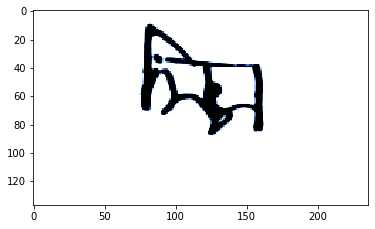

In [0]:
idx = 60000
img = data[idx]
plt.imshow(np.transpose(img['image'].numpy(), (1,2,0)))

# Models

In [0]:
import pretrainedmodels
import torch.nn as nn
import torch
from torch.nn import functional as F

In [0]:
class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained:  
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)

        #168 grapheme
        self.l0 = nn.Linear(512, 168)
        # 11 vowel
        self.l1 = nn.Linear(512, 11)
        # 7 consonant
        self.l2 = nn.Linear(512, 7)

    def forward(self, x):
        bs, _, _,_ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        l0 = self.l0(x)
        l1 = self.l1(x)
        l2 = self.l2(x)
        return l0, l1, l2

In [0]:
model = ResNet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


# Train

In [0]:
# import os
# import ast

# DEVICE = "cuda"
# TRAINING_FOLDS_CSV = os.environ.get("TRAINING_FOLDS_CSV")
# IMG_HEIGHT = int(os.environ.get("IMG_HEIGHT"))
# IMG_WIDTH = int(os.environ.get("IMG_WIDTH"))
# EPOCHS = int(os.environ.get("EPOCHS"))

# TRAIN_BATCH_SIZE = int(os.environ.get("TRAIN_BATCH_SIZE"))
# TEST_BATCH_SIZE = int(os.environ.get("TEST_BATCH_SIZE"))

# IMAGE_MEAN = ast.literal_eval(os.environ.get("MODEL_MEAN"))
# IMAGE_STD = ast.literal_eval(os.environ.get("MODEL_STD"))

# TRAINING_FOLDS = int(os.environ.get("TRAINING_FOLDS"))
# VALIDATION_FOLDS = int(os.environ.get("VALIDATION_FOLDS"))
# BASE_MODEL = os.environ.get("BASE_MODEL")

import os
import ast

DEVICE = "cuda"
TRAINING_FOLDS_CSV = "input/train_folds.csv"
IMG_HEIGHT = 137
IMG_WIDTH = 236
EPOCHS = 5

TRAIN_BATCH_SIZE = 356
TEST_BATCH_SIZE = 224

IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

TRAINING_FOLDS = (0,1,2,3)
VALIDATION_FOLDS = (4,)
BASE_MODEL = model

In [0]:
import torch
from tqdm import tqdm

In [0]:
#train

def main():

    model = ResNet34(pretrained=True)
    model.to(DEVICE)

    train_dataset = BengaliDatasetTrain(folds=TRAINING_FOLDS,
                                        img_height = IMG_HEIGHT,
                                        img_width = IMG_WIDTH,
                                        mean = IMAGE_MEAN,
                                        std = IMAGE_STD)
     
    #train dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size= TRAIN_BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=4)
    
    valid_dataset = BengaliDatasetTrain(folds=VALIDATION_FOLDS,
                                        img_height = IMG_HEIGHT,
                                        img_width = IMG_WIDTH,
                                        mean = IMAGE_MEAN,
                                        std=IMAGE_STD)
    
    #validation dataloader
    val_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size= TEST_BATCH_SIZE,
                                             shuffle=False,
                                             num_workers=4)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, 
                                                           mode="min", 
                                                           patience=5, 
                                                           factor=0.3, 
                                                           verbose=True)


    for epoch in range(EPOCHS):
        print("training............")
        train(train_dataset, train_loader, model, optimizer)
        print("validating............")
        val_score = evaluate(valid_dataset, val_loader, model)
        scheduler.step(val_score)
        torch.save(model.state_dict(), f"resnet_34_fold{VALIDATION_FOLDS[0]}.bin")

In [0]:
def train(dataset, dataloader, model, optimizer):
    model.train()
    final_loss = 0
    counter = 0
    for bi, d in tqdm(enumerate(dataloader), total=len(dataset)/dataloader.batch_size):
        counter = counter+1
        image = d['image'].to(DEVICE, dtype=torch.float)
        grapheme_root = d['grapheme_root'].to(DEVICE, dtype=torch.long)
        vowel_diacritic = d['vowel_diacritic'].to(DEVICE, dtype=torch.long)
        consonant_diacritic = d['consonant_diacritic'].to(DEVICE, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(image)
        targets = (grapheme_root, vowel_diacritic, consonant_diacritic)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        final_loss += loss
    print("train loss : ", final_loss / counter)

In [0]:
def evaluate(dataset, dataloader, model):
    model.eval()
    final_loss = 0
    counter = 0
    with torch.no_grad():
        for bi, d in tqdm(enumerate(dataloader), total=len(dataset)/dataloader.batch_size):
            counter = counter+1
            image = d['image'].to(DEVICE, dtype=torch.float)
            grapheme_root = d['grapheme_root'].to(DEVICE, dtype=torch.long)
            vowel_diacritic = d['vowel_diacritic'].to(DEVICE, dtype=torch.long)
            consonant_diacritic = d['consonant_diacritic'].to(DEVICE, dtype=torch.long)
            outputs = model(image)
            targets = (grapheme_root, vowel_diacritic, consonant_diacritic)
            loss = loss_fn(outputs, targets)
            final_loss += loss
        print("test loss : ", final_loss / counter)

    return final_loss / counter

In [0]:
def loss_fn(outputs, targets):
    o1, o2, o3 = outputs
    t1, t2, t3 = targets

    l1 = nn.CrossEntropyLoss()(o1, t1)
    l2 = nn.CrossEntropyLoss()(o1, t2)
    l3 = nn.CrossEntropyLoss()(o1, t3)
    return (l1+l2+l3) / 3

In [21]:
main()

training............


452it [24:06,  2.66s/it]                                       


train loss :  tensor(1.8402, device='cuda:0', grad_fn=<DivBackward0>)
validating............


180it [01:41,  1.78it/s]                                        


test loss :  tensor(1.2979, device='cuda:0')
training............


452it [24:08,  2.67s/it]                                       


train loss :  tensor(1.2283, device='cuda:0', grad_fn=<DivBackward0>)
validating............


180it [01:41,  1.79it/s]                                        


test loss :  tensor(1.1945, device='cuda:0')
training............


452it [24:08,  2.67s/it]                                       


train loss :  tensor(1.1615, device='cuda:0', grad_fn=<DivBackward0>)
validating............


180it [01:41,  1.78it/s]                                        


test loss :  tensor(1.1705, device='cuda:0')
training............


452it [24:08,  2.67s/it]                                       


train loss :  tensor(1.1329, device='cuda:0', grad_fn=<DivBackward0>)
validating............


180it [01:41,  1.78it/s]                                        


test loss :  tensor(1.1469, device='cuda:0')
training............


452it [24:08,  2.67s/it]                                       


train loss :  tensor(1.1125, device='cuda:0', grad_fn=<DivBackward0>)
validating............


180it [01:41,  1.78it/s]                                        


test loss :  tensor(1.1379, device='cuda:0')


In [0]:
!nvidia-smi